In [2]:
import re
import random
import pandas as pd
import hashlib

In [3]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.5) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.1


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [4]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure Developer Associate,121.923018,8.128201,12.875781,15
PEP 8,274.947628,91.649209,113.103002,3
Python,704.196881,14.982912,26.394654,47
Todd Ideas,1067.208029,71.147202,158.180674,15
OData,1748.432844,291.405474,564.418023,6
SharePoint,1767.404070,147.283672,589.260702,12
Audit Report Tracker (Sharepoint List),1879.610912,144.585455,374.655161,13
Azure Functions + Visual Studio,2047.669375,146.262098,489.450813,14
Debugging in VS Code,2088.087612,104.404381,273.335092,20
IW Migration,2241.746171,160.124727,474.490678,14


# Histogram

79563.18


<Axes: >

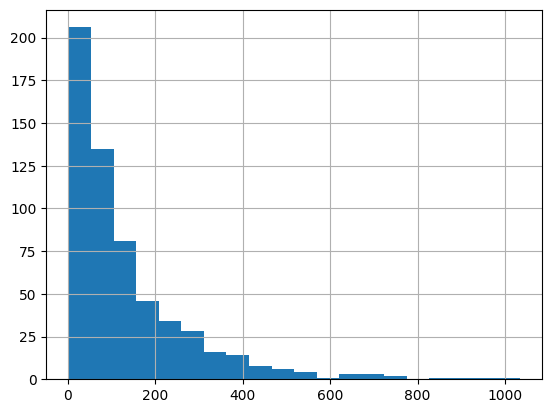

In [5]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [8]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [9]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [10]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [11]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [12]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [13]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [14]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Age Max

In [15]:
n = 1
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 591


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
69,Logging in Python,Q: What does the exc_info parameter do in logg...,99985def14861364c32ddb3b87ea135b,-1033.056688,151.716897,-1033.056688,9103.013846,0.429699,0,0
21,Email Auth and Security,Identifier Alignment\n\nEnsuring that the doma...,74a89604ca7b2e38b605e5efbb01fe47,-901.573629,185.996268,-901.573629,2417.951485,0.151120,0,0
138,Vocab,Boustrophedonic\nadjective\nSPA: boo-struh-fee...,c778949e7f683ddbc9ae9910ad5c565c,-872.050644,107.548088,-872.050644,7098.173790,0.136302,0,0
5,Azure Functions,2. Suppose your Azure Function has a blob trig...,fc5054fcf13b3189012cf676692c4f29,-751.683701,271.563604,-751.683701,2987.199646,0.724319,0,0
0,Azure AI Search,"After the first indexer run, you can rerun it ...",32962e9b2ebb8fe8f74b47cd3080634c,-733.094959,276.430564,-733.094959,3870.027902,0.543766,0,0
46,Powershell Modules,PowerShell Gallery\n\nDefinition: The central ...,92931a76329cd1bec63d78a358648c4d,-683.626805,166.048290,-683.626805,4981.448700,0.082812,0,0
26,PnP Powershell,SharePoint REST API\nA set of web services pro...,143745e569af1c6a779118128bf12b60,-664.637340,182.576836,-664.637340,6937.919779,0.719949,0,0
95,SharePoint,How can you retrieve the metadata of a specifi...,a9bef1ae5a68637d2ee73d72c0aa7e47,-589.260702,147.283672,-589.260702,1767.404070,0.817981,0,0
203,OData,Namespaces\n\nDefinition: Unique identifiers (...,c37dc59fe7d7fe68df3c7d713fa0d170,-564.418023,291.405474,-564.418023,1748.432844,0.081785,0,0
99,Azure Functions + Visual Studio,ASP.NET includes a variety of built-in securit...,22f41dbaa7f06bfee2174c4754c8f951,-489.450813,146.262098,-489.450813,2047.669375,0.277725,0,0


## Card Count

In [16]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)




## Random

In [17]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [18]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
69,Logging in Python,Q: What does the exc_info parameter do in logg...,99985def14861364c32ddb3b87ea135b,-1033.056688,151.716897,-1033.056688,9103.013846,0.429699,0,0
21,Email Auth and Security,Identifier Alignment\n\nEnsuring that the doma...,74a89604ca7b2e38b605e5efbb01fe47,-901.573629,185.996268,-901.573629,2417.951485,0.151120,0,0
138,Vocab,Boustrophedonic\nadjective\nSPA: boo-struh-fee...,c778949e7f683ddbc9ae9910ad5c565c,-872.050644,107.548088,-872.050644,7098.173790,0.136302,0,0
5,Azure Functions,2. Suppose your Azure Function has a blob trig...,fc5054fcf13b3189012cf676692c4f29,-751.683701,271.563604,-751.683701,2987.199646,0.724319,0,0
0,Azure AI Search,"After the first indexer run, you can rerun it ...",32962e9b2ebb8fe8f74b47cd3080634c,-733.094959,276.430564,-733.094959,3870.027902,0.543766,0,0
46,Powershell Modules,PowerShell Gallery\n\nDefinition: The central ...,92931a76329cd1bec63d78a358648c4d,-683.626805,166.048290,-683.626805,4981.448700,0.082812,0,0
26,PnP Powershell,SharePoint REST API\nA set of web services pro...,143745e569af1c6a779118128bf12b60,-664.637340,182.576836,-664.637340,6937.919779,0.719949,0,0
95,SharePoint,How can you retrieve the metadata of a specifi...,a9bef1ae5a68637d2ee73d72c0aa7e47,-589.260702,147.283672,-589.260702,1767.404070,0.817981,0,0
203,OData,Namespaces\n\nDefinition: Unique identifiers (...,c37dc59fe7d7fe68df3c7d713fa0d170,-564.418023,291.405474,-564.418023,1748.432844,0.081785,0,0
99,Azure Functions + Visual Studio,ASP.NET includes a variety of built-in securit...,22f41dbaa7f06bfee2174c4754c8f951,-489.450813,146.262098,-489.450813,2047.669375,0.277725,0,0


In [19]:
existing_cards['age'].mean()

-134.62466631438764